ایمپورت کرئن کنابخانه های مورد نیاز

In [4]:
import os
import time as time
import tensorflow as tf
import numpy as np
np.random.seed(40)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
%matplotlib inline

from PIL import Image
import time
from datetime import timedelta
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import skimage.morphology as morp
from skimage.filters import rank

import keras

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dropout # new!
from keras.layers.normalization import BatchNormalization # new!
from keras import regularizers # new! 
from keras.optimizers import SGD
from keras.layers import Flatten, Conv2D, MaxPooling2D # new!
from keras.callbacks import ModelCheckpoint

import cv2


اتصال به درایو

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


تقسیم بندی دیتاست یه مجموعه های اموزشی و ارزشیابی و تست

In [5]:
import pickle
training_file = "train.pickle"
testing_file = "test.pickle"
validation_file = "valid.pickle"
with open(training_file, mode='rb') as file:
    train = pickle.load(file)
with open(testing_file, mode='rb') as file:
    test = pickle.load(file)
with open(validation_file, mode='rb') as file:
    valid = pickle.load(file)
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
X_valid , y_valid = valid['features'], valid['labels']


تعداد دیتای هر مجموعه

In [6]:
print (len(X_train))
print(len(y_test))
print(len(X_valid))
print(np.shape(X_train[1]))
print(len(np.unique(y_train)))
classNumber = len(np.unique(y_train))


34799
12630
4410
(32, 32, 3)
43


نشان دادن تعداد دیتای هر کلاس

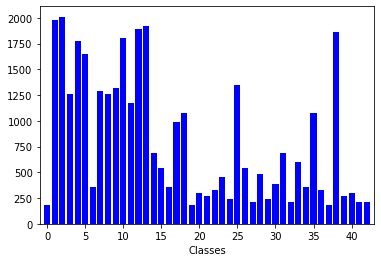

In [7]:

classes,data_number = np.unique(y_train, return_counts = True)
pyplot.bar( np.arange( 43 ), data_number,color='blue' )
pyplot.xlabel('Classes')
pyplot.xlim([-1, 43])
pyplot.show()


نشان دادن بخشی از دیتا

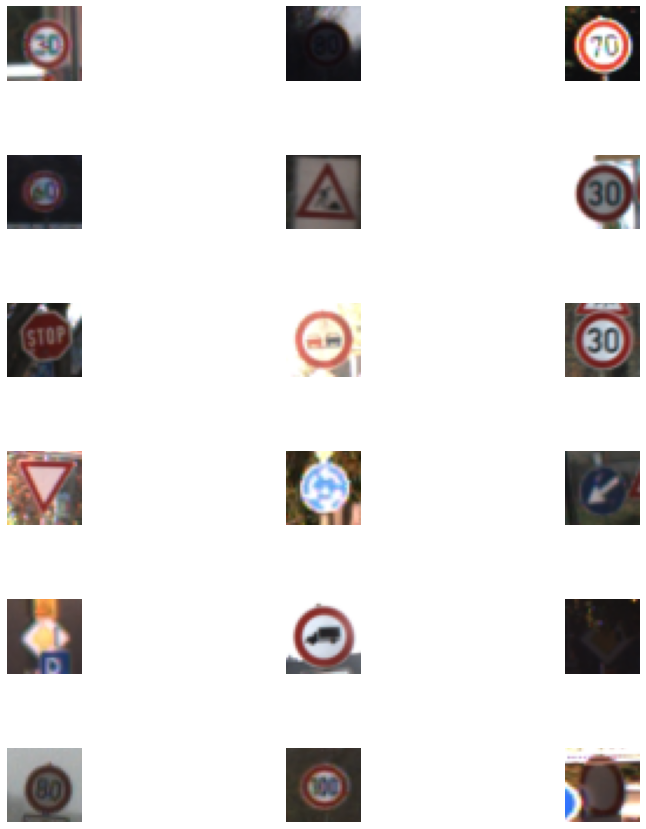

In [8]:



import matplotlib.pyplot as plt
import random

%matplotlib inline
f_show, a_show = plt.subplots(6,3, figsize=(15, 15))
f_show.subplots_adjust(hspace =1, wspace=.001)
a_show = a_show.ravel()
for j in range(18):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    a_show[j].axis('off')
    a_show[j].imshow(image)

    
    



تبدیل دیتا ها به  مناسب برای اموزش شبکه

اضافه و کامل کردن *دیتاها*


In [10]:
def augmentation(image):
    rows= image.shape[0]
    cols = image.shape[1]
    
    # rotation
    M_rot = cv2.getRotationMatrix2D((cols/2,rows/2),10,1)
    
    # Translation
    M_trans = np.float32([[1,0,3],[0,1,6]])
    
    
    img = cv2.warpAffine(image,M_rot,(cols,rows))
    img = cv2.warpAffine(img,M_trans,(cols,rows))
    
    img = cv2.bilateralFilter(img,9,75,75)
    return img


افزایش تعداد دیتاهای مجموعه اموزشی و برابر کردن تعداد دیتاهای هر کلاس

کپی گرفتن از مجموعه اصلی

In [11]:
classes = 43
X_train_final = X_train
y_train_final = y_train

افزایش تعداد دیتاها و رساندن تعداد دیتاهای هر کلاس به 3000

In [12]:

X_after_augmentation = []
Y_after_augmentation = []
for i in range(0,classes):
    
    class_records = np.where(y_train==i)[0].size
    max_records = 3000
    if class_records != max_records:
        add_number_data = max_records - class_records
        samples = X_train[np.where(y_train==i)[0]]
        X_aug = []
        Y_aug = [i] * add_number_data 
        
        for x in range(add_number_data ):
            img = samples[x % class_records]
            trans_img = augmentation(img)
            X_aug.append(trans_img)
            
        X_train_final = np.concatenate((X_train_final, X_aug), axis=0)
        y_train_final = np.concatenate((y_train_final, Y_aug)) 
        
        Y_after_augmentation = Y_after_augmentation + Y_aug
        X_after_augmentation = X_after_augmentation + X_aug
        
  
    

برابر شدن تعداد دیتاها در هر کلاس

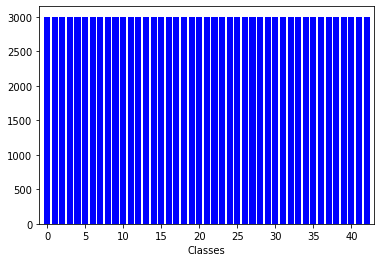

In [13]:
classes,data_number = np.unique(y_train_final, return_counts = True)
pyplot.bar( np.arange( 43 ), data_number,color='blue' )
pyplot.xlabel('Classes')
pyplot.xlim([-1, 43])
pyplot.show()

دیتا بعد از اگمنتیشن

In [14]:
print(len(X_train))
print(len(X_train_final))
print(len(y_train))
print(len(y_train_final))

34799
129000
34799
129000


نمومه از دیتا ها پس از اضافه کردن و برابر کردن تعداد دیتاها در هر کلاس

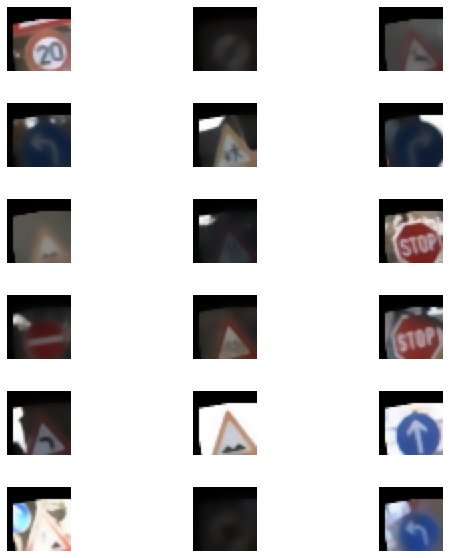

In [15]:
import matplotlib.pyplot as plt
import random

%matplotlib inline
f_show, a_show = plt.subplots(6,3, figsize=(10, 10))
f_show.subplots_adjust(hspace = .5, wspace=.001)
a_show = a_show.ravel()
for i in range(18):
    index = random.randint(0, len(X_after_augmentation))
    image = X_after_augmentation[index]
    a_show[i].axis('off')
    a_show[i].imshow(image)
   
    

تبدیل دیتا ها به شکل مناسب برای اموزش شبکه

In [16]:
X_train_aug = X_train_final.reshape(len(X_train_final), 32,32,3).astype('float32')
X_valid_aug = X_valid.reshape(len(X_valid), 32,32,3).astype('float32')
y_train_aug = keras.utils.to_categorical(y_train_final, classNumber)
y_valid_aug = keras.utils.to_categorical(y_valid, classNumber)
print(X_train_aug.shape)
print(y_train_aug.shape)
print(X_valid_aug.shape)
print(y_valid_aug.shape)


(129000, 32, 32, 3)
(129000, 43)
(4410, 32, 32, 3)
(4410, 43)


In [17]:
X_test_aug = X_test.reshape(len(X_test), 32,32,3).astype('float32')
y_test_aug = keras.utils.to_categorical(y_test, classNumber)

ایجاد شبکه  

In [40]:
model_conv = Sequential()
model_conv.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=(32, 32, 3)))
model_conv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Dropout(0.5))
model_conv.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Dropout(0.5))
model_conv.add(Flatten())
model_conv.add(Dense(128, activation='relu'))
model_conv.add(Dropout(0.5))
model_conv.add(Dense(classNumber, activation='softmax'))


In [41]:
model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
history1=model_conv.fit(X_train_aug , y_train_aug , batch_size=128, epochs=4, verbose=1,validation_data=(X_valid_aug, y_valid_aug))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


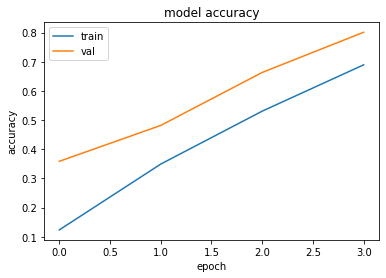

In [47]:
print(history1.history.keys())
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

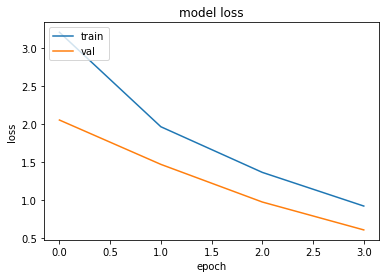

In [49]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model_conv.save('my_model.h5')
model_conv.summary()

In [35]:
new_model = tf.keras.models.load_model('my_model.h5')

new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)       36992     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 128)       147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 128)        

In [50]:
Pred_conv = new_model.evaluate(X_test_aug, y_test_aug, verbose=2)


395/395 - 25s - loss: 0.4096 - accuracy: 0.9017


اعمال کردن gray scaleروی مجموعه اموزشی

(129000, 32, 32)


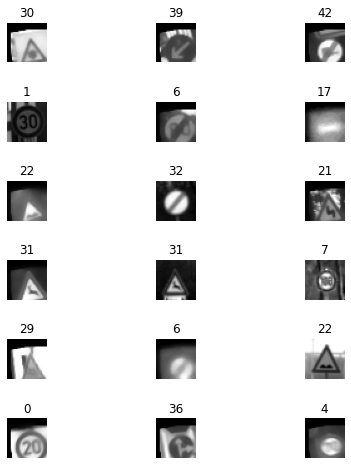

In [ ]:
def gray_scale(image):
    
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images_data = list(map(gray_scale, X_train_final))
print(local_histo.shape)

%matplotlib inline
f_show, a_show = plt.subplots(6,3, figsize=(8, 8))
f_show.subplots_adjust(hspace = 1, wspace=.001)
a_show = a_show.ravel()
for i in range(18):
    index = np.random.randint(0, len(gray_images_data))
    image = gray_images_data[index]
    a_show[i].axis('off')
    a_show[i].imshow(image,cmap='gray')
    a_show[i].set_title(y_train_final[index])
  



اضافه کردن  
Histogram
Equalization
به داده های اموزشی

(129000, 32, 32)


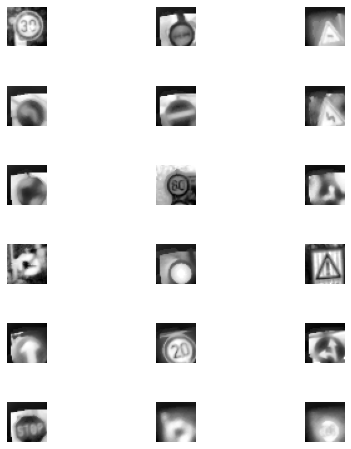

In [ ]:
def histo_equalize(image):
    
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local


local_histo = np.array(list(map(histo_equalize, gray_images_data)))
print(local_histo.shape)
%matplotlib inline
f_show, a_show = plt.subplots(6,3, figsize=(8, 8))
f_show.subplots_adjust(hspace =1, wspace=.001)
a_show = a_show.ravel()
for i in range(18):
    index = np.random.randint(0, len(local_histo))
    image = local_histo[index]
    a_show[i].axis('off')
    a_show[i].imshow(image,cmap = 'gray')
 
 

ساختن مجوعه ها و ایجاد شیپ مناسب برای اموزش شبکه

In [ ]:
X_train_preprocessed =  np.array(list(map(histo_equalize, gray_images_data)))
X_valid_preprocessed = np.array(list(map(histo_equalize, list(map(gray_scale, X_valid)))))

In [ ]:
X_train_preprocessed_dn = X_train_preprocessed.reshape(len(X_train_preprocessed), 32*32*1).astype('float32')
print(X_train_preprocessed_dn.shape)

X_valid_preprocessed_dn = X_valid_preprocessed.reshape(len(X_valid_preprocessed), 32*32*1).astype('float32')
print(X_valid_preprocessed_dn.shape)


(129000, 1024)
(4410, 1024)


In [ ]:
y_train_final_dn = keras.utils.to_categorical(y_train_final, classNumber)
y_valid_final_dn = keras.utils.to_categorical(y_valid, classNumber)


In [ ]:
print(X_train_preprocessed_dn.shape)
print(X_valid_preprocessed_dn.shape)
print(y_train_final_dn.shape)
print(y_valid_final_dn.shape)

(129000, 1024)
(4410, 1024)
(129000, 43)
(4410, 43)


In [ ]:

X_test_preprocessed =np.array(list(map(histo_equalize, list(map(gray_scale, X_test)))))
X_test_preprocessed_dn = X_test_preprocessed.reshape(len(X_test_preprocessed), 32*32*1).astype('float32')
y_test_final_dn = keras.utils.to_categorical(y_test, classNumber)


In [ ]:
print(X_test_preprocessed_dn.shape)
print(y_test_final_dn.shape)


(12630, 1024)
(12630, 43)


ساخت و اموزش شبکه عصبی قبل ب داده های جدید پس از اعمال 
Histogram
Equalization
و
gray scale

In [ ]:
# Prepare data for Conv nets
X_train_preprocessed_cn = X_train_preprocessed.reshape(len(X_train_preprocessed), 32,32,1).astype('float32')
X_valid_preprocessed_cn = X_valid_preprocessed.reshape(len(X_valid_preprocessed), 32,32,1).astype('float32')
X_test_preprocessed_cn = X_test_preprocessed.reshape(len(X_test_preprocessed), 32,32,1).astype('float32')


In [ ]:
y_train_final_cn = keras.utils.to_categorical(y_train_final, classNumber)
y_valid_final_cn = keras.utils.to_categorical(y_valid, classNumber)
y_test_final_cn = keras.utils.to_categorical(y_test, classNumber)
print(X_train_preprocessed_cn.shape)
print(X_valid_preprocessed_cn.shape)
print(X_test_preprocessed_cn.shape)
print(y_train_final_cn.shape)
print(y_valid_final_cn.shape)
print(y_test_final_cn.shape)

(129000, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)
(129000, 43)
(4410, 43)
(12630, 43)


In [ ]:
model_conv2 = Sequential()
model_conv2.add(Conv2D(32, kernel_size=(3, 3),activation='relu', input_shape=(32, 32, 1)))
model_conv2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv2.add(MaxPooling2D(pool_size=(2, 2)))
model_conv2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv2.add(MaxPooling2D(pool_size=(2, 2)))
model_conv2.add(Dropout(0.25))
model_conv2.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model_conv2.add(MaxPooling2D(pool_size=(2, 2)))
model_conv2.add(Dropout(0.5))
model_conv2.add(Flatten())
model_conv2.add(Dense(128, activation='relu'))
model_conv2.add(Dropout(0.5))
model_conv2.add(Dense(classNumber, activation='softmax'))


In [ ]:
model_conv2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
model_conv2.fit(X_train_preprocessed_cn , y_train_final_cn , batch_size=128, epochs=4, verbose=1,validation_data=(X_valid_preprocessed_cn, y_valid_final_cn))

Epoch 1/4
1008/1008 [==============================] - 838s 831ms/step - loss: 2.9920 - accuracy: 0.1923 - val_loss: 1.3191 - val_accuracy: 0.5694
Epoch 2/4
1008/1008 [==============================] - 832s 826ms/step - loss: 1.1534 - accuracy: 0.6359 - val_loss: 0.4188 - val_accuracy: 0.8907
Epoch 3/4
1008/1008 [==============================] - 834s 827ms/step - loss: 0.5612 - accuracy: 0.8263 - val_loss: 0.1783 - val_accuracy: 0.9590
Epoch 4/4
1008/1008 [==============================] - 829s 822ms/step - loss: 0.3874 - accuracy: 0.8826 - val_loss: 0.0962 - val_accuracy: 0.9721


پیش بینی مدل روس داده تست

In [ ]:
Pred_conv = model_conv2.evaluate(X_test_preprocessed_cn, y_test_final_cn, verbose=2)
print("%s- %.2f" % ( model_conv2.metrics_names[0], Pred_conv[0]))
print("%s- %.2f" % ( model_conv2.metrics_names[1], Pred_conv[1]))

395/395 - 18s - loss: 0.2093 - accuracy: 0.9405
loss- 0.21
accuracy- 0.94


In [ ]:
model_conv2.save('my_model23.h5')
